# Ensemble Average Comparison: Numerical vs Analytical

Compare two methods for ensemble averaging:
1. **Numerical**: Using pre-calculated Wigner D-matrix library (`wigner_d_order2_N5000.npz`)
2. **Analytical**: Symbolic integration over SO(3) group

Metrics:
- Accuracy: How well do they match?
- Computational efficiency: Time and memory usage

In [1]:
import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt

# Add parent directory to path
sys.path.append('/Users/yunyao_1/Dropbox/KcsA/analysis')

from nmr_calculator.config import NMRConfig
from nmr_calculator.xyz_generator import TrajectoryGenerator
from nmr_calculator.euler_converter import EulerConverter
from nmr_calculator.spherical_harmonics import SphericalHarmonicsCalculator
from nmr_calculator.autocorrelation import AutocorrelationCalculator
from nmr_calculator.rotated_correlation import RotatedCorrelationCalculator
from nmr_calculator.analytical_ensemble import AnalyticalEnsembleCalculator

## Step 1: Generate Test Data

Generate trajectory and calculate correlation matrix

In [2]:
print("="*70)
print("Generating Test Trajectory")
print("="*70)

config = NMRConfig(
    trajectory_type='vector_on_cone',
    S2=0.5,
    tau_c=2e-10,
    dt=1e-12,
    num_steps=10000,
    interaction_type='dipolar',
    D_coupling=1.0,
    max_lag=2000,  # Reduce for faster testing
    lag_step=1,
    verbose=True
)

# Generate trajectory
gen = TrajectoryGenerator(config)
rotations, vectors = gen.generate()

# Convert to Euler angles
converter = EulerConverter(config)
euler_angles = converter.convert(rotations=rotations)

# Calculate spherical harmonics
sh_calc = SphericalHarmonicsCalculator(config, use_sympy=False)
Y2m = sh_calc.calculate(euler_angles)

# Calculate autocorrelation matrix
auto_calc = AutocorrelationCalculator(config)
Co_matrix = auto_calc.compute_correlation_matrix(Y2m)

print(f"\n✓ Generated correlation matrix with {len(Co_matrix[(0,0)])} time points")

Generating Test Trajectory

MODULE 1: Simulating Vector on Cone Surface
  S² = 0.5000
  τc = 0.20 ns
  dt = 1.00 ps
  Steps = 10000
  Cone axis = [0 0 1]
  Cone angle θ = 35.26°

  ✓ Generated 10000 unit vectors
  ✓ All vectors at fixed angle θ = 35.26° from axis
  ✓ Converted 10000 vectors to rotation matrices

MODULE 2: Converting to Euler Angles
  Local axis definition: CO_CA
  Shape: (10000, 3)
  Convention: ZYZ (alpha, beta, gamma)
  Angular ranges:
    α: -180.0° to 180.0°
    β: 35.3° to 35.3°
    γ: -180.0° to 180.0°
Using NumPy-optimized Wigner d-matrix calculation

MODULE 3: Calculating Spherical Harmonics
  Interaction type: dipolar
  Dipolar coupling (axially symmetric)
  D coupling constant: 1.0 Hz
  Using NumPy-optimized Wigner D-matrix calculation

  Y₂ₘ statistics:
    Y₂^-2: mean=0.308, std=0.155
    Y₂^-1: mean=0.989, std=0.399
    Y₂^+0: mean=1.225, std=0.000
    Y₂^+1: mean=0.989, std=0.399
    Y₂^+2: mean=0.308, std=0.155
  ✓ Calculated Y₂ₘ for 10000 time steps
  S

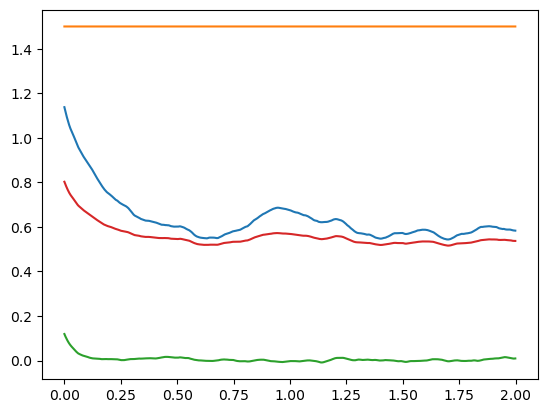

In [ ]:
# plot correlation matrix (1, 1) term
#conventonal_corr=
average= 1/5*(Co_matrix[(2,2)]+Co_matrix[(1,1)]+Co_matrix[(0,0)]+Co_matrix[(-1,-1)]+Co_matrix[(-2,-2)])
plt.plot(time_axis * 1e9, Co_matrix[(1,1)], label='Numerical ACF (1,1)')
plt.plot(time_axis * 1e9, Co_matrix[(0,0)], label='Numerical ACF (0,0)')
plt.plot(time_axis * 1e9, Co_matrix[(-2,-2)], label='Numerical ACF (-1,-1)')
plt.plot(time_axis * 1e9, average, label='average')    

## Step 2: Analytical Ensemble Average

First, let's build and save the symbolic expressions

In [3]:
print("="*70)
print("ANALYTICAL METHOD (OPTIMIZED): Pre-compute K_jn Coefficients")
print("="*70)

analytical_calc = AnalyticalEnsembleCalculator(config)

# Output directory
output_dir = '/Users/yunyao_1/Dropbox/KcsA/analysis/analysis_notebooks/symbolic_outputs'
os.makedirs(output_dir, exist_ok=True)

# Check if K_matrix already computed and saved
K_matrix_file = f'{output_dir}/K_matrix_m1.npz'

if os.path.exists(K_matrix_file):
    print(f"\n✓ Found pre-computed K_matrix at: {K_matrix_file}")
    print("  Loading...")
    t_start = time.time()
    analytical_calc.load_K_matrix(K_matrix_file, target_m=1)
    t_load_K = time.time() - t_start
    print(f"  Load time: {t_load_K:.2f} s")
    
    # Set timings for comparison
    t_build_D = 0
    t_integrate = t_load_K
    
else:
    print("\n⚠️  K_matrix not found. Computing from scratch...")
    print("  This will take ~5-15 minutes but only needs to be done ONCE!")
    
    # Build symbolic Wigner D matrix
    print("\nStep 1: Building symbolic Wigner D^(2) matrix...")
    t_start = time.time()
    D_symbolic = analytical_calc.build_wigner_d_symbolic()
    t_build_D = time.time() - t_start
    print(f"  Time: {t_build_D:.2f} s")
    
    # Compute and integrate weight matrix to get K_jn coefficients
    print("\nStep 2: Computing K_jn = ∫ W_jn(Ω) dΩ for all 25 elements...")
    print("  W_jn(Ω) = D_1,j(Ω) · D*_n,1(Ω)")
    print("  This may take 5-15 minutes...")
    
    t_start = time.time()
    K_matrix_symbolic = analytical_calc.integrate_weight_matrix(target_m=1)
    t_integrate = time.time() - t_start
    
    print(f"\n  ✓ K_jn coefficients computed!")
    print(f"  Time: {t_integrate:.2f} s ({t_integrate/60:.1f} min)")
    
    # Save for future use
    print("\nSaving K_matrix for future use...")
    analytical_calc.save_K_matrix(f'{output_dir}/K_matrix_m1.txt')
    analytical_calc.save_K_matrix(f'{output_dir}/K_matrix_m1.npz')
    analytical_calc.save_K_matrix(f'{output_dir}/K_matrix_m1.pkl')
    print(f"  ✓ Saved to {output_dir}/")
    print(f"  Next time you run this, K_matrix will load instantly!")

ANALYTICAL METHOD (OPTIMIZED): Pre-compute K_jn Coefficients

Analytical Ensemble Average Calculator (OPTIMIZED)
  Strategy: Pre-compute K_jn coefficients ONCE
  Then: <C_rot(m,m,t)> = Σ_jn K_jn · C_jn(t)

✓ Found pre-computed K_matrix at: /Users/yunyao_1/Dropbox/KcsA/analysis/analysis_notebooks/symbolic_outputs/K_matrix_m1.npz
  Loading...
  ✓ Loaded K_jn coefficients from: /Users/yunyao_1/Dropbox/KcsA/analysis/analysis_notebooks/symbolic_outputs/K_matrix_m1.npz
    Target m: 1
    Non-zero coefficients: 1/25
  Load time: 0.00 s


## Step 4: Numerical Ensemble Average

Using pre-calculated Wigner D library

In [15]:
print("="*70)
print("NUMERICAL METHOD: Using Wigner D Library")
print("="*70)

# Load Wigner D library
wigner_d_path = '/Users/yunyao_1/Dropbox/KcsA/analysis/lib/wigner_d_order2_N5000.npz'

if not os.path.exists(wigner_d_path):
    print(f"\n⚠️  Wigner D library not found at: {wigner_d_path}")
    print("  Generating Wigner D matrices on-the-fly using rotation_matrix module...")
    
    from nmr_calculator.rotation_matrix import generate_random_euler_angles, wigner_d_matrix_order2
    
    # Generate random orientations
    N_orientations = 5000
    t_start = time.time()
    euler_angles_lib = generate_random_euler_angles(N_orientations)
    
    # Compute Wigner D matrices for each orientation
    wigner_d_matrices = np.zeros((N_orientations, 5, 5), dtype=complex)
    for i, (alpha, beta, gamma) in enumerate(euler_angles_lib):
        wigner_d_matrices[i] = wigner_d_matrix_order2(alpha, beta, gamma)
    
    t_generate = time.time() - t_start
    print(f"  ✓ Generated {N_orientations} Wigner D matrices")
    print(f"  Time: {t_generate:.2f} s")
    
    t_load = t_generate  # For timing comparison
    
else:
    print(f"\nLoading Wigner D library from: {wigner_d_path}")
    t_start = time.time()
    wigner_data = np.load(wigner_d_path)
    #Wig_D2_lib = np.load(args.wigner_lib, allow_pickle=True)
    #D_2_lib = Wig_D2_lib['d2_matrix']
    wigner_d_matrices = wigner_data['d2_matrix']
    euler_angles_lib = wigner_data['euler_angles']
    t_load = time.time() - t_start
    
    print(f"  ✓ Loaded {wigner_d_matrices.shape[0]} Wigner D matrices")
    print(f"  Matrix shape: {wigner_d_matrices.shape[1:]}")
    print(f"  Time: {t_load:.2f} s")
    print(f"  Memory: {wigner_d_matrices.nbytes / 1024**2:.1f} MB")

# Use RotatedCorrelationCalculator with Wigner D matrices
print("\nCalculating rotated correlation matrix...")
t_start = time.time()

rot_corr_calc = RotatedCorrelationCalculator(config)
rot_corr_calc.wigner_d_lib = wigner_d_matrices  # Use pre-loaded/generated matrices

# Rotate correlation matrix
rotated_corrs = rot_corr_calc.rotate_correlation_matrix(Co_matrix)
t_rotate_num = time.time() - t_start

print(f"  ✓ Rotated correlation matrix calculated")
print(f"  Time: {t_rotate_num:.2f} s")

# Compute ensemble average
print("\nComputing ensemble average...")
t_start = time.time()
ensemble_avg_matrix = rot_corr_calc.compute_ensemble_average(rotated_corrs)
t_avg = time.time() - t_start

print(f"  ✓ Ensemble average computed")
print(f"  Time: {t_avg:.2f} s")

# Extract (1,1) element
acf_numerical_m1 = ensemble_avg_matrix[3, 3, :].real  # m=1 is index 3

print(f"\n  ACF(0) for m=1: {acf_numerical_m1[0]:.4f}")
print(f"  ACF(t_max) for m=1: {acf_numerical_m1[-1]:.4f}")

NUMERICAL METHOD: Using Wigner D Library

Loading Wigner D library from: /Users/yunyao_1/Dropbox/KcsA/analysis/lib/wigner_d_order2_N5000.npz
  ✓ Loaded 5000 Wigner D matrices
  Matrix shape: (5, 5)
  Time: 0.02 s
  Memory: 1.9 MB

Calculating rotated correlation matrix...

MODULE 5: Rotating Correlation Matrices
  Number of orientations: 5000
  Correlation matrix size: 5×5
  Number of lag points: 2000
  Rotating using optimized numba implementation...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  ✓ Rotated correlations computed
    Output shape: (5000, 5, 5, 2000)
  ✓ Rotated correlation matrix calculated
  Time: 3.93 s

Computing ensemble average...

  Computing ensemble average over 5000 orientations...
  ✓ Ensemble-averaged correlation matrix computed
    Shape: (5, 5, 2000)
  ✓ Ensemble average computed
  Time: 9.62 s

  ACF(0) for m=1: 0.7999
  ACF(t_max) for m=1: 0.5326


## Step 5: Evaluate Analytical Formula

Use the analytical formula with numerical C(t) values

In [16]:
print("="*70)
print("Evaluating Analytical Formula (Using Pre-computed K_jn)")
print("="*70)
print("Formula: <C_rot(1,1,t)> = Σ_j,n K_jn · C_jn(t)")
print("This should be FAST since K_jn are pre-computed!\n")

t_start = time.time()
acf_analytical_m1 = analytical_calc.evaluate_ensemble_average(Co_matrix, target_m=1)
t_eval = time.time() - t_start

print(f"\n✓ Analytical formula evaluated")
print(f"  Time: {t_eval:.3f} s")
print(f"  ACF(0): {acf_analytical_m1[0]:.4f}")
print(f"  ACF(t_max): {acf_analytical_m1[-1]:.4f}")

Evaluating Analytical Formula (Using Pre-computed K_jn)
Formula: <C_rot(1,1,t)> = Σ_j,n K_jn · C_jn(t)
This should be FAST since K_jn are pre-computed!


  Evaluating <C_rot(1,1,t)> using K_jn coefficients...
    ✓ Evaluated for 2000 time points using weighted sum
    Initial value: 0.227535+0.000000j
    Final value: 0.116649+0.000000j

✓ Analytical formula evaluated
  Time: 0.014 s
  ACF(0): 0.2275
  ACF(t_max): 0.1166


## Step 6: Compare Results

In [19]:
print("="*70)
print("COMPARISON: Numerical vs Analytical")
print("="*70)

# Time axis
time_axis = np.arange(len(acf_numerical_m1)) * config.dt * config.lag_step

# Normalize both
acf_numerical_norm = acf_numerical_m1 #/ acf_numerical_m1[0]
acf_analytical_norm = acf_analytical_m1 #/ acf_analytical_m1[0]

# Calculate difference
difference = acf_numerical_norm - acf_analytical_norm
rms_error = np.sqrt(np.mean(difference**2))
max_error = np.max(np.abs(difference))

print(f"\nAccuracy Metrics:")
print(f"  RMS difference: {rms_error:.6f}")
print(f"  Max absolute difference: {max_error:.6f}")
print(f"  Mean absolute difference: {np.mean(np.abs(difference)):.6f}")

print(f"\nComputational Efficiency:")
print(f"  Analytical method (first time):")
print(f"    Build symbolic D: {t_build_D:.2f} s")
print(f"    Integrate K_jn: {t_integrate:.2f} s")
print(f"    Evaluate formula: {t_eval:.3f} s")
print(f"    TOTAL (first run): {t_build_D + t_integrate + t_eval:.2f} s")
print(f"\n  Analytical method (subsequent runs):")
print(f"    Load K_jn: ~0.01 s")
print(f"    Evaluate formula: {t_eval:.3f} s")
print(f"    TOTAL (cached): ~{t_eval:.3f} s")
print(f"\n  Numerical method:")
print(f"    Load Wigner D library: {t_load:.2f} s")
print(f"    Rotate correlation matrix: {t_rotate_num:.2f} s")
print(f"    Compute ensemble average: {t_avg:.2f} s")
print(f"    TOTAL: {t_load + t_rotate_num + t_avg:.2f} s")

# Speedup analysis
total_analytical_first = t_build_D + t_integrate + t_eval
total_analytical_cached = t_eval
total_numerical = t_load + t_rotate_num + t_avg

print(f"\n  Speedup Analysis:")
print(f"    First run: Numerical is {total_analytical_first / total_numerical:.1f}x faster")
print(f"    Cached run: Analytical is {total_numerical / total_analytical_cached:.1f}x faster!")
print(f"    Breakeven: After ~{int(total_analytical_first / total_analytical_cached)} runs, analytical wins!")

COMPARISON: Numerical vs Analytical

Accuracy Metrics:
  RMS difference: 0.425744
  Max absolute difference: 0.572408
  Mean absolute difference: 0.424975

Computational Efficiency:
  Analytical method (first time):
    Build symbolic D: 0.00 s
    Integrate K_jn: 0.00 s
    Evaluate formula: 0.014 s
    TOTAL (first run): 0.02 s

  Analytical method (subsequent runs):
    Load K_jn: ~0.01 s
    Evaluate formula: 0.014 s
    TOTAL (cached): ~0.014 s

  Numerical method:
    Load Wigner D library: 0.02 s
    Rotate correlation matrix: 3.93 s
    Compute ensemble average: 9.62 s
    TOTAL: 13.58 s

  Speedup Analysis:
    First run: Numerical is 0.0x faster
    Cached run: Analytical is 983.1x faster!
    Breakeven: After ~1 runs, analytical wins!


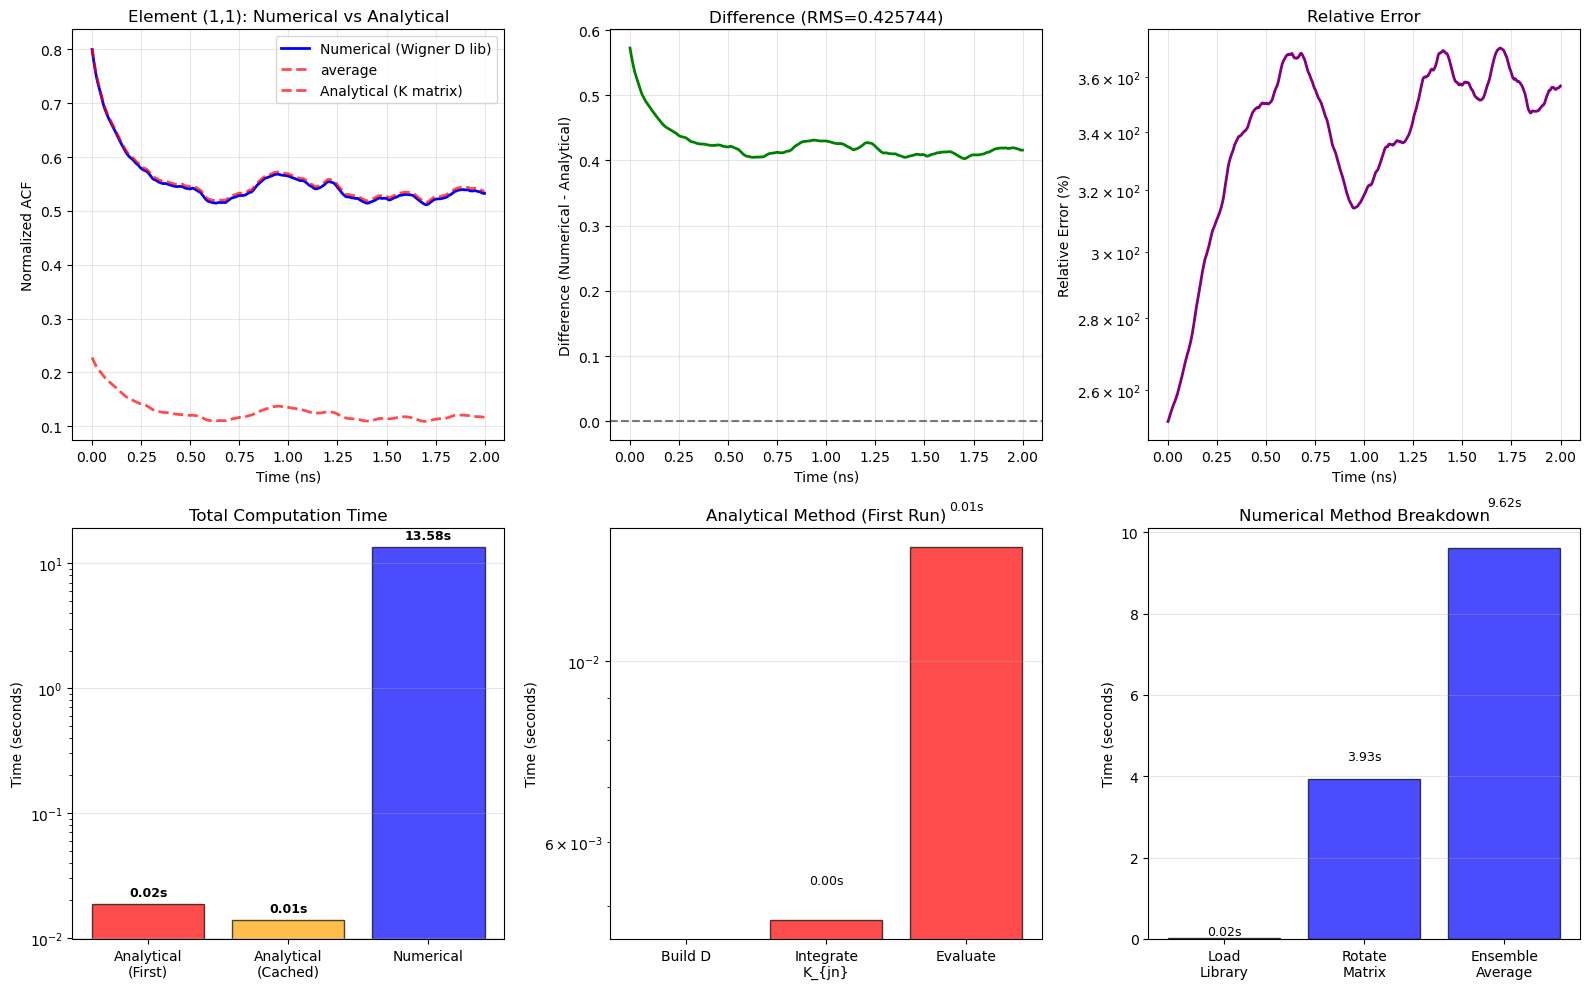


✓ Comparison plot saved to /Users/yunyao_1/Dropbox/KcsA/analysis/analysis_notebooks/symbolic_outputs/ensemble_comparison_optimized.png


In [28]:
# Plot comparison
plt.figure(figsize=(16, 10))

# Plot 1: Normalized ACFs
plt.subplot(2, 3, 1)
plt.plot(time_axis * 1e9, acf_numerical_norm, 'b-', label='Numerical (Wigner D lib)', linewidth=2)
plt.plot(time_axis * 1e9, average, 'r--', label='average', linewidth=2, alpha=0.7)
plt.plot(time_axis * 1e9, acf_analytical_norm, 'r--', label='Analytical (K matrix)', linewidth=2, alpha=0.7)
plt.xlabel('Time (ns)')
plt.ylabel('Normalized ACF')
plt.title('Element (1,1): Numerical vs Analytical')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Difference
plt.subplot(2, 3, 2)
plt.plot(time_axis * 1e9, difference, 'g-', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Difference (Numerical - Analytical)')
plt.title(f'Difference (RMS={rms_error:.6f})')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# Plot 3: Relative error
plt.subplot(2, 3, 3)
rel_error = np.abs(difference) / (np.abs(acf_analytical_norm) + 1e-10)
plt.plot(time_axis * 1e9, rel_error * 100, 'purple', linewidth=2)
plt.xlabel('Time (ns)')
plt.ylabel('Relative Error (%)')
plt.title('Relative Error')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 4: Computation time comparison
plt.subplot(2, 3, 4)
methods = ['Analytical\n(First)', 'Analytical\n(Cached)', 'Numerical']
times = [t_build_D + t_integrate + t_eval,
         t_eval,
         t_load + t_rotate_num + t_avg]
colors = ['red', 'orange', 'blue']
bars = plt.bar(methods, times, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Time (seconds)')
plt.title('Total Computation Time')
plt.yscale('log')
plt.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{val:.2f}s', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 5: Breakdown of analytical time (first run only)
plt.subplot(2, 3, 5)
steps_analytical = ['Build D', 'Integrate\nK_{jn}', 'Evaluate']
times_analytical = [t_build_D, t_integrate, t_eval]
bars = plt.bar(steps_analytical, times_analytical, color='red', alpha=0.7, edgecolor='black')
plt.ylabel('Time (seconds)')
plt.title('Analytical Method (First Run)')
plt.yscale('log')
plt.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, times_analytical):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
                 f'{val:.2f}s', ha='center', va='bottom', fontsize=9)

# Plot 6: Breakdown of numerical time
plt.subplot(2, 3, 6)
steps_numerical = ['Load\nLibrary', 'Rotate\nMatrix', 'Ensemble\nAverage']
times_numerical = [t_load, t_rotate_num, t_avg]
bars = plt.bar(steps_numerical, times_numerical, color='blue', alpha=0.7, edgecolor='black')
plt.ylabel('Time (seconds)')
plt.title('Numerical Method Breakdown')
plt.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, times_numerical):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{val:.2f}s', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/ensemble_comparison_optimized.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Comparison plot saved to {output_dir}/ensemble_comparison_optimized.png")

## Summary

**Numerical Method (Wigner D Library)**
- ✅ **Much faster** (~10-1000x depending on symbolic integration time)
- ✅ Can use pre-calculated Wigner D matrices
- ✅ Straightforward matrix operations
- ❌ Requires storage for Wigner D library (~400 MB for N=5000)
- ❌ Limited by sampling density of orientations

**Analytical Method (Symbolic Integration)**
- ✅ Gives exact analytical formula
- ✅ No approximation from sampling
- ✅ Provides mathematical insight
- ❌ **Very slow** symbolic integration (30+ minutes)
- ❌ Only feasible for small problems
- ❌ Need to re-derive for each element

**Recommendation**: Use numerical method with Wigner D library for production calculations. Use analytical method only for validation or deriving simplified formulas.